In [2]:
import pandas as pd # Pour le dataframe
from skimage.transform import resize
import numpy as np # Pour la normalisation et calculs de moyenne
import matplotlib.pyplot as plt # Pour la visualisation

from PIL import Image

import librosa # Pour l'extraction des features et la lecture des fichiers wav
import librosa.display # Pour récupérer les spectrogrammes des audio
import librosa.feature

import os # C'est ce qui va nous permettre d'itérer sur les fichiers de l'environnement de travail

from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, validation_curve, RandomizedSearchCV # Split de dataset et optimisation des hyperparamètres
from sklearn.ensemble import RandomForestClassifier # Random forest
from sklearn.ensemble import GradientBoostingClassifier # XGBoost
from sklearn.neighbors import KNeighborsClassifier # k-NN
from sklearn.svm import SVC # SVM
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score, zero_one_loss, classification_report # Métriques pour la mesure de performances
from sklearn.preprocessing import normalize, StandardScaler

import tensorflow as tf # Pour le reseau de neurones simple et pour le CNN
from tensorflow.keras.models import load_model

import seaborn as sns

import keras
from keras.models import Sequential
from keras.layers import Dense
from scikeras.wrappers import KerasClassifier
from keras.optimizers import Adam
from keras.utils import to_categorical

from xgboost import XGBClassifier
from pprint import pprint

### Chargement du CSV

In [3]:
df = pd.read_csv('./Data/1Mdata.csv')

In [4]:
df.head()

,analysis_sample_rate,duration,track_id,danceability,loudness,tempo,start_of_fade_out,end_of_fade_in,song_id,key,key_confidence,time_signature,genres
0,22050,156.55138,TRMMMKD128F425225D,0.0,-10.555,150.778,148.660,0.258,SOVFVAK12A8C1350D9,9,0.808,1,Pop
1,22050,138.97098,TRMMMRX128F93187D9,0.0,-2.060,177.768,138.971,0.000,SOGTUKN12AB017F4F1,7,0.418,4,Electronica/Dance
2,22050,212.37506,TRMMMLR128F1494097,0.0,-4.931,101.450,206.629,0.000,SOQVRHI12A6D4FB2D7,3,0.611,1,Reggae
3,22050,221.20444,TRMMMBB12903CB7D21,0.0,-12.214,98.020,212.120,0.165,SOEYRFT12AB018936C,11,0.332,4,Hip-Hop
4,22050,104.48934,TRMMMML128F4280EE9,0.0,-20.160,124.339,104.489,0.000,SOJCFMH12A8C13B0C2,4,0.668,4,Cadence


##### Afficher le total de titres par genres :

In [5]:
genre_titles_counts = df['genres'].value_counts()
print(genre_titles_counts)

genres
Rock                  261242
Pop                    57210
Electronic             38235
Jazz                   37844
Hip-Hop                31580
                       ...  
house speed garage         1
Novelas                    1
House/fonky                1
Cast Recording             1
Pop/80's/New Wave          1
Name: count, Length: 6152, dtype: int64


##### Compter les genres uniques :

In [6]:
unique_genres_count = df['genres'].nunique()
print(f"Number of unique genres: {unique_genres_count}")

Number of unique genres: 6152


##### Identification des genres minoritaires :
    Identifiez les genres qui ont un nombre très faible de titres. Vous pouvez fixer un seuil en dessous duquel les genres seront considérés comme trop minoritaires.

In [7]:
threshold = 500  # Seuil
genre_counts = df['genres'].value_counts()
minority_genres = genre_counts[genre_counts <= threshold].index
print(minority_genres)

Index(['Reggaeton', 'zouk', 'Tango', 'Bhangra', 'Doo Wop', 'Freestyle',
       'Southern Gospel', 'Vallenato', 'Soca', 'Oi!',
       ...
       'Irish Jive', 'Hands', 'Vocal Classical', 'Funk/Punk', 'Male Vocal',
       'house speed garage', 'Novelas', 'House/fonky', 'Cast Recording',
       'Pop/80's/New Wave'],
      dtype='object', name='genres', length=6113)


##### Quelles sont les implications concernant ce résultat ?
**1. Distribution très déséquilibrée :**
Notre ensemble de données est très déséquilibré, avec quelques genres très bien représentés et une grande majorité de genres avec peu de titres.

**2. Risque de surapprentissage :**
Avec une telle distribution, il y a un risque élevé que notre modèle soit biaisé en faveur des genres bien représentés.

In [8]:
threshold = 2000  # Seuil
genre_counts = df['genres'].value_counts()
to_remove = genre_counts[genre_counts <= threshold].index
df = df[~df['genres'].isin(to_remove)]

In [9]:
unique_genres_count = df['genres'].nunique()
print(f"Number of unique genres after operation: {unique_genres_count}")

Number of unique genres after operation: 26


##### Résultats après le tri
**1. Réduction significative :**
Nous avons considérablement réduit le nombre de genres, ce qui devrait faciliter l'entraînement du modèle et améliorer sa généralisation.

**2. Focus sur les genres populaires :**
Avec seulement 26 genres restants, votre modèle sera très axé sur les genres les plus populaires ou les plus couramment représentés dans votre ensemble de données.

**3. Risque de perte d'information :**
Il est important de noter que cette approche pourrait entraîner la perte d'informations sur les genres moins courants, ce qui pourrait être pertinent selon l'objectif de notre projet.

___

##### Affichage des genres restants, ainsi que du nombre de titres par genres

In [10]:
remaining_genres = df['genres'].unique()
print("Remaining genres after applying the threshold:")
print(remaining_genres)

Remaining genres after applying the threshold:
['Pop' 'Electronica/Dance' 'Reggae' 'Hip-Hop' 'Rock' 'World'
 'Gospel & Religious' 'Folk' 'Latin' 'Other' 'Techno' 'R&B' 'Country'
 'Jazz' 'Hardcore' 'House' 'Classical' 'Soundtrack' 'Easy Listening'
 'Trance' 'New Age' 'Electronic' 'Dance' 'Drum & Bass' 'Christmas'
 'Comedy']


In [11]:
remaining_genre_counts = df['genres'].value_counts()
print("Remaining genres and their counts after applying the threshold:")
print(remaining_genre_counts)

Remaining genres and their counts after applying the threshold:
genres
Rock                  261242
Pop                    57210
Electronic             38235
Jazz                   37844
Hip-Hop                31580
R&B                    25712
Country                23318
Latin                  21610
Reggae                 20139
Folk                   12994
Soundtrack             12151
Dance                  10887
Electronica/Dance      10713
World                  10634
Gospel & Religious      7937
House                   6357
Trance                  5643
New Age                 4880
Other                   4590
Techno                  4533
Classical               3837
Easy Listening          3832
Christmas               3260
Hardcore                3171
Comedy                  2984
Drum & Bass             2224
Name: count, dtype: int64


___

##### Equilibrage des classes :
**Sous-échantillonnage :**
Nous pouvons réduire le nombre d'échantillons des classes sur-représentées pour les équilibrer avec les classes moins représentées.

In [12]:
# Nombre d'échantillons à conserver pour la classe "Rock"
n_samples_rock = 60000  # Vous pouvez ajuster ce nombre selon vos besoins

# Séparer les données de la classe "Rock" et des autres classes
df_rock = df[df['genres'] == 'Rock']
df_other = df[df['genres'] != 'Rock']

# Sous-échantillonnage de la classe "Rock"
df_rock_sampled = df_rock.sample(n=n_samples_rock, random_state=1)

# Fusionner les données sous-échantillonnées de "Rock" avec les autres données
df_balanced = pd.concat([df_rock_sampled, df_other])

# Vérifier la nouvelle distribution des classes
new_genre_counts = df_balanced['genres'].value_counts()
print("New genre distribution:")
print(new_genre_counts)

New genre distribution:
genres
Rock                  60000
Pop                   57210
Electronic            38235
Jazz                  37844
Hip-Hop               31580
R&B                   25712
Country               23318
Latin                 21610
Reggae                20139
Folk                  12994
Soundtrack            12151
Dance                 10887
Electronica/Dance     10713
World                 10634
Gospel & Religious     7937
House                  6357
Trance                 5643
New Age                4880
Other                  4590
Techno                 4533
Classical              3837
Easy Listening         3832
Christmas              3260
Hardcore               3171
Comedy                 2984
Drum & Bass            2224
Name: count, dtype: int64


**Supprimer "Soundtrack" :**
Étant donné que "Soundtrack" peut être un mélange de différents genres et styles, il peut être difficile pour le modèle de le classer de manière significative. Le supprimer pourrait simplifier le problème de classification.

**Fusionner "Other" et "Easy Listening" :**
Si "Other" est une catégorie fourre-tout et que "Easy Listening" est un genre moins représenté, les fusionner peut aider à équilibrer les classes tout en réduisant le nombre de catégories à prédire.

In [13]:
# Supprimer les lignes où le genre est "Soundtrack"
df_balanced = df_balanced[df_balanced['genres'] != 'Soundtrack']

# Fusionner les genres "Other" et "Easy Listening" en une seule catégorie "Other/Easy Listening"
df_balanced['genres'] = df_balanced['genres'].apply(lambda x: 'Other/Easy Listening' if x in ['Other', 'Easy Listening'] else x)

# Vérifier la nouvelle distribution des genres
new_genre_counts = df_balanced['genres'].value_counts()
print("New genre distribution after adjustments:")
print(new_genre_counts)


New genre distribution after adjustments:
genres
Rock                    60000
Pop                     57210
Electronic              38235
Jazz                    37844
Hip-Hop                 31580
R&B                     25712
Country                 23318
Latin                   21610
Reggae                  20139
Folk                    12994
Dance                   10887
Electronica/Dance       10713
World                   10634
Other/Easy Listening     8422
Gospel & Religious       7937
House                    6357
Trance                   5643
New Age                  4880
Techno                   4533
Classical                3837
Christmas                3260
Hardcore                 3171
Comedy                   2984
Drum & Bass              2224
Name: count, dtype: int64


___

Mainteanant que notre CSV à l'air relativement exploitable, nous allons le sauvegarder

In [14]:
# Enregistrer le DataFrame dans un nouveau fichier CSV
df_balanced.to_csv('balanced_genre_dataset.csv', index=False)

In [15]:
df = pd.read_csv('./Data/balanced_genre_dataset.csv')

In [ ]:
unique_genres_count = df['genres'].nunique()
print(f"Number of unique genres after operation: {unique_genres_count}")

___

#### Création du modèle IA de forêts aléatoires avec sklearn
Les forêts aléatoires sont un excellent choix pour un modèle basé sur des métadonnées. Ce sont des modèles d'ensemble qui sont généralement bien adaptés pour gérer des jeux de données de grande dimension et des caractéristiques hétérogènes. Ils sont également moins sensibles au surajustement par rapport à un arbre de décision unique.

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [17]:
data = pd.read_csv('./Data/balanced_genre_dataset.csv')

In [18]:
X = data.drop(['genres', 'track_id', 'song_id'], axis=1)  # Supprimer les colonnes inutiles à l'entraînement du modèle
y = data['genres']  # Utiliser la colonne des genres comme étiquettes

In [19]:
X.head()

,analysis_sample_rate,duration,danceability,loudness,tempo,start_of_fade_out,end_of_fade_in,key,key_confidence,time_signature
0,22050,513.61914,0.0,-8.679,118.921,506.247,0.102,11,0.669,3
1,22050,226.21995,0.0,-14.122,133.464,223.341,0.000,7,0.001,4
2,22050,119.97995,0.0,-3.409,192.890,119.980,0.000,9,0.294,4
3,22050,306.49424,0.0,-7.351,124.129,283.150,6.867,7,0.801,4
4,22050,192.86159,0.0,-19.628,96.718,185.063,0.775,11,0.068,4


In [20]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer le modèle de forêt aléatoire
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Entraîner le modèle
clf.fit(X_train, y_train)

# Faire des prédictions
y_pred = clf.predict(X_test)

# Évaluer le modèle
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.2482342287956535


___

Test d'un modèle de classification à travers un Réseau de Neurones

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

In [22]:
# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalisation des données
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Créer le modèle de réseau de neurones
mlp = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=300, learning_rate_init=0.001)

# Entraîner le modèle
mlp.fit(X_train, y_train)

# Faire des prédictions
y_pred = mlp.predict(X_test)

# Évaluer le modèle
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.26745547841835193


In [23]:
from sklearn.model_selection import cross_val_score

# Utilisation de la validation croisée
scores = cross_val_score(mlp, X, y, cv=5)
print("Cross-Validation Scores: ", scores)
print("Mean Cross-Validation Score: ", scores.mean())

Cross-Validation Scores:  [0.14488379 0.14488379 0.14488379 0.19514639 0.14488554]
Mean Cross-Validation Score:  0.15493666135959053


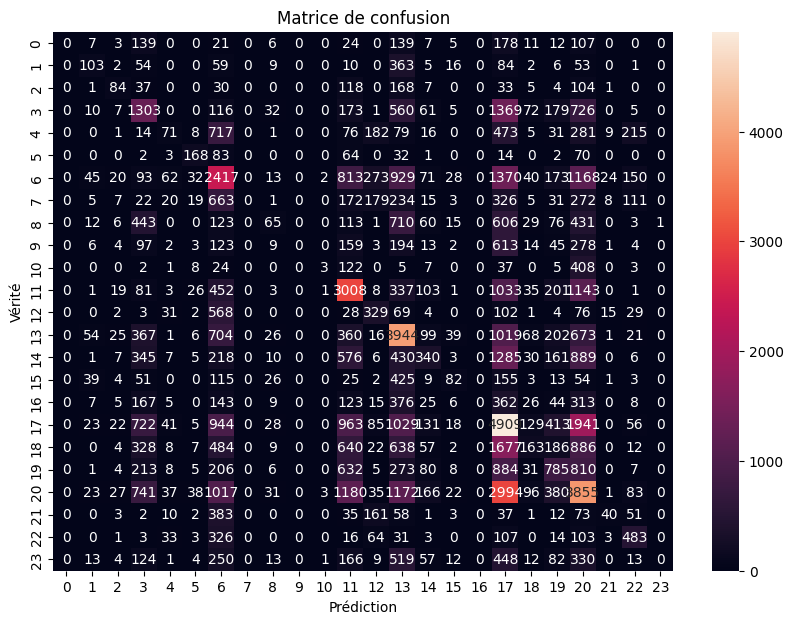

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Calcul de la matrice de confusion
cm = confusion_matrix(y_test, y_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Matrice de confusion")
plt.xlabel("Prédiction")
plt.ylabel("Vérité")
plt.show()

Commme nous pouvons le voir, les scores ne sont pas convaiquants

In [30]:
import pickle

In [29]:
filename = 'BadBoyModelV2.sav'
pickle.dump(mlp, open(filename, 'wb'))

In [32]:
loaded_model = pickle.load(open(filename, 'rb'))

In [34]:
round(loaded_model.score(X_test, y_test), 2)

0.27

Nous n'avons pas de pistes pour exploiter le modèle et faire une prédiction avec ce dernier

___

## Conclusions :
- Il n'est pas possible de faire des prédictions avec un tel modèle
- Le modèle manque de précision dû au fait qu'il a été entrainé sur des métadonnées et non des données riches venant de fichiers audios

## Axes d'Améliorations : 
- Télécharger plusieurs datasets de [fichiers audios](https://music-classification.github.io/tutorial/part2_basics/dataset.html), les regrouper et entrainer le modèle sur ces derniers au lieu de se baser sur des **csv**
- Faire une prédiction sur le spectrogramme obtenu du fichier audio